In [1]:
# %matplotlib qt
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt     
import matplotlib
import tensorflow as tf
import seaborn as sns

In [2]:
# matplotlib settings
matplotlib.rcParams['figure.figsize'] = [20, 10]
sns.set(style="white")

In [5]:
# Import Data Frame

# Specify path
LOG_NUM =  9003
PATH_TO_DF = r"C:\Users\lukas\OneDrive\Universität\Mathematik\Bachelorarbeit\log_dir\Special Simulations\log_{}\SIMULATION_SUMMARY\simulation_summary_log_{}.pkl".format(LOG_NUM, LOG_NUM)
PATH_TO_MODEL = r"C:\Users\lukas\OneDrive\Universität\Mathematik\Bachelorarbeit\log_dirSpecial Simulations\log_{}\WEIGHTS\1".format(
    LOG_NUM
)

# Load data, calculate accuracy, remove greedy choices
df = pd.read_pickle(PATH_TO_DF)
df_wo_greedy = df[df["greedy"]==0]

In [6]:
# Inspect the simulation results
df.tail()

,agent_choice_of_x1,agent_final_cash_balance,cumulative_liquidity_costs,episode,greedy,initial_state,optimal_choice_of_x1,optimal_final_cash_balance
49995,6.45,16.757311,-3.079240,49995,1,"[[5.0], [10.0], [1.0], [0.0]]",3.811821,16.666403
49996,5.23,13.451253,-1.049601,49996,0,"[[5.0], [10.0], [1.0], [0.0]]",3.811821,13.987279
49997,5.02,16.556753,-1.788328,49997,1,"[[5.0], [10.0], [1.0], [0.0]]",3.811821,16.401746
49998,7.33,14.181824,-3.090103,49998,1,"[[5.0], [10.0], [1.0], [0.0]]",3.811821,15.272143
49999,5.12,13.563491,-1.024015,49999,0,"[[5.0], [10.0], [1.0], [0.0]]",3.811821,14.034422


In [7]:
# CLASS DEFINITION FOR PERFECT STRATEGY VALUE CALCULATION
class optimal_strategy:
    def __init__(self, alpha, lower_bound, upper_bound, mu, x_0, y_0, S_0):
        self.alpha=alpha
        self.mu = mu
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.x_0 = x_0
        self.y_0 = y_0
        self.S_0 = S_0
    
    def phi(self, x):
        return (np.exp(self.alpha*x)-1)/self.alpha
    
    def get_gamma(self):
        return np.log((self.y_0*self.alpha)/self.S_0 + 1)*(1/self.alpha)+ self.x_0
    
    def get_x_1(self):
        x_1 = (np.log(self.mu) + self.x_0*self.alpha)/(2*self.alpha)
        gamma = self.get_gamma()
        if x_1 < 0:
            return 0
        elif x_1 > gamma:
            return gamma
        else:
            return x_1
        
    def get_expv(self):
        x_1 = self.get_x_1()
        return self.y_0 - self.phi(x_1-self.x_0)*self.S_0 - self.phi(-x_1)*self.S_0 * self.mu
    
    def get_vola_distribution(self):
        return (1/12)*(self.upper_bound - self.lower_bound)**2
    
    def get_std(self):
        x_1 = self.get_x_1()
        vol = self.get_vola_distribution()
        return (self.phi(-x_1)**2*self.S_0**2*vol)**0.5   
    
    def get_liquidity_costs(self):
        x_1 = self.get_x_1()
        period_1_costs = (-self.phi(x_1-self.x_0) + (x_1 - self.x_0))*self.S_0
        print(f"period_1_costs: {period_1_costs}")
        cumulative_costs = (self.y_0 - self.phi(x_1 - self.x_0)*self.S_0 - self.phi(-x_1)*self.S_0 * self.mu) -\
        (self.y_0 - (x_1 - self.x_0)*self.S_0 - (-x_1)*self.S_0 * self.mu)
        print(f"period_2_costs: {cumulative_costs + period_1_costs}")
        print(f"cumulative_costs: {cumulative_costs}")
        return cumulative_costs
    
    def calculate_liquidity_costs_for_custom_x_1(self, x_1):
        period_1_costs = (-self.phi(x_1-self.x_0) + (x_1 - self.x_0))*self.S_0
        print(f" CUSTOM: period_1_costs: {period_1_costs}")
        cumulative_costs = (self.y_0 - self.phi(x_1 - self.x_0)*self.S_0 - self.phi(-x_1)*self.S_0 * self.mu)- \
        (self.y_0 - (x_1 - self.x_0)*self.S_0 - (-x_1)*self.S_0 * self.mu)
        
        print(f" CUSTOM: period_2_costs: {cumulative_costs + period_1_costs}")
        print(f" CUSTOM: cumulative_costs: {cumulative_costs}")
        return cumulative_costs
        
              
    def get_values(self):
        return {"x_1":self.get_x_1(),
               "expv":self.get_expv(),
               "std":self.get_std(),
               "cumulative liquidity costs": self.get_liquidity_costs()}


In [9]:
# OPTIMAL STRATEGY VALUES

parameters = {"alpha":0.1, "mu":1.3, "lower_bound":0.8, "upper_bound":1.8, "x_0":5, "y_0":10, "S_0":1}

policy = optimal_strategy(**parameters)

policy_values = policy.get_values()

print(policy_values, "\n")

print(policy.calculate_liquidity_costs_for_custom_x_1(0))

period_1_costs: -0.06787381672235049
period_2_costs: -0.9708104915431972
cumulative_costs: -0.9029366748208467
{'x_1': 3.811821322337455, 'expv': 15.24060972188039, 'std': 0.9149458156181324, 'cumulative liquidity costs': -0.9029366748208467} 

 CUSTOM: period_1_costs: -1.0653065971263342
 CUSTOM: period_2_costs: -2.130613194252668
 CUSTOM: cumulative_costs: -1.0653065971263338
-1.0653065971263338


# PLOT 1: Choice of x_1 & Final cash balance

In [19]:
X = "episode"
Y_1 = "agent_choice_of_x1"
Y_1_MA = "agent_choice_of_x1_ma"
Y_2 = "agent_final_cash_balance"
Y_2_MA = "agent_final_cash_balance_ma"

MA = 250

X_data = df_wo_greedy[X]
Y_1_data = df_wo_greedy[Y_1]
Y_1_MA_data = df_wo_greedy[Y_1].rolling(window=MA).mean()
Y_2_data = df_wo_greedy[Y_2]
Y_2_MA_data = df_wo_greedy[Y_2].rolling(window=MA).mean()

df_plot_1 = pd.DataFrame(
{
    X: X_data,
    Y_1: Y_1_data,
    Y_1_MA: Y_1_MA_data,
    Y_2: Y_2_data,
    Y_2_MA: Y_2_MA_data,
})

df_plot_1.head()

,episode,agent_choice_of_x1,agent_choice_of_x1_ma,agent_final_cash_balance,agent_final_cash_balance_ma
4153,4153,7.180,NaN,15.869117,NaN
4183,4183,7.180,NaN,14.945332,NaN
4494,4494,7.150,NaN,14.437979,NaN
4550,4550,7.145,NaN,16.426107,NaN
4556,4556,7.145,NaN,15.014087,NaN


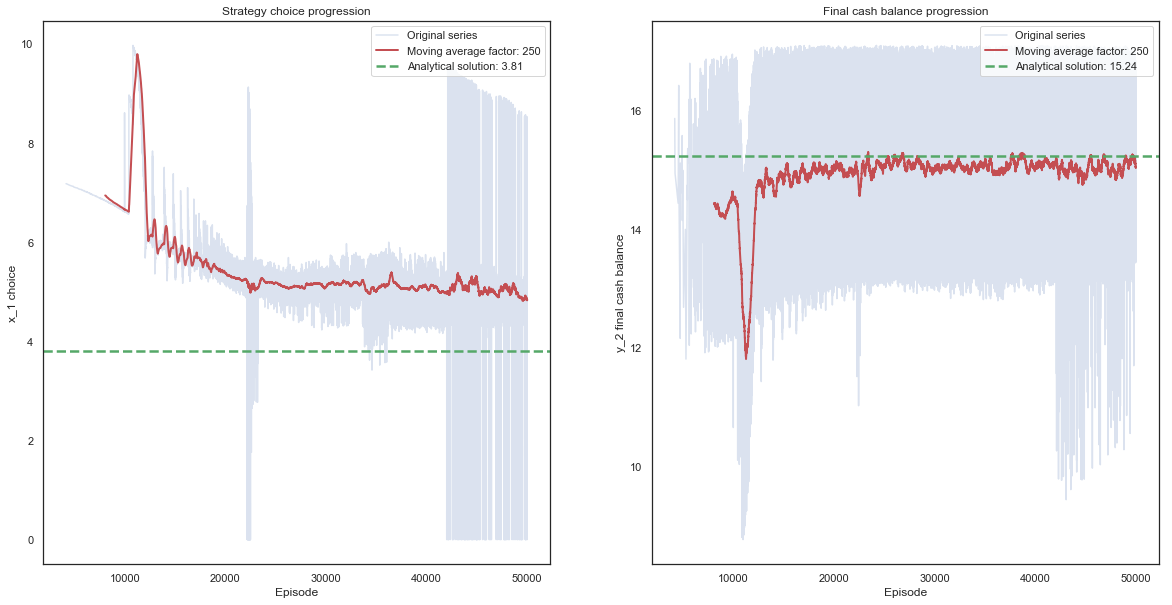

In [20]:
fig, ax = plt.subplots(1,2)
opacity = 0.2

sns.lineplot(x="episode", y=Y_1, data=df_plot_1, label="Original series", ax=ax[0], alpha=opacity, color="b")
sns.lineplot(x="episode", y=Y_1_MA, data=df_plot_1, label=f"Moving average factor: {MA}", ax=ax[0], color="r", linewidth=2)

sns.lineplot(x="episode", y=Y_2, data=df_plot_1, label="Original series", ax=ax[1], alpha=opacity, color="b")
sns.lineplot(x="episode", y=Y_2_MA, data=df_plot_1, label=f"Moving average factor: {MA}", ax=ax[1], color="r", linewidth=2)

ax[0].set(title="Strategy choice progression", xlabel="Episode", ylabel="x_1 choice")
ax[1].set(title="Final cash balance progression", xlabel="Episode", ylabel="y_2 final cash balance")

ax[0].axhline(policy_values["x_1"], ls='--', label="Analytical solution: {}".format(round(policy_values["x_1"], 2)), c="g", linewidth=2.5)
ax[1].axhline(policy_values["expv"], ls='--', label="Analytical solution: {}".format(round(policy_values["expv"], 2)), c="g", linewidth=2.5)

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

plt.savefig(fname=r"C:\Users\lukas\OneDrive\Universität\Mathematik\Bachelorarbeit\Latex\BA_main\figures\test_res\two_p_2_1.png", bbox_inches = 'tight', pad_inches = 0)
# plt.show()

# PLOT 2: Cumulative liquidity costs & Rolling Std final cash balance

In [21]:
X = "episode"
Y_1 = "cumulative_liquidity_costs"
Y_1_MA = "cumulative_liquidity_costs_ma"
Y_2_MA = "agent_final_cash_balance_ma"

MA = 250

X_data = df_wo_greedy[X]
Y_1_data = df_wo_greedy[Y_1]
Y_1_MA_data = df_wo_greedy[Y_1].rolling(window=MA).mean()
Y_2_MA_data = df_wo_greedy[Y_2].rolling(window=MA).std()

df_plot_1 = pd.DataFrame(
{
    X: X_data,
    Y_1: Y_1_data,
    Y_1_MA: Y_1_MA_data,
    Y_2_MA: Y_2_MA_data,
})

df_plot_1.head()

,episode,cumulative_liquidity_costs,cumulative_liquidity_costs_ma,agent_final_cash_balance_ma
4153,4153,-3.591118,NaN,NaN
4183,4183,-3.220130,NaN,NaN
4494,4494,-2.981504,NaN,NaN
4550,4550,-3.769849,NaN,NaN
4556,4556,-3.205838,NaN,NaN


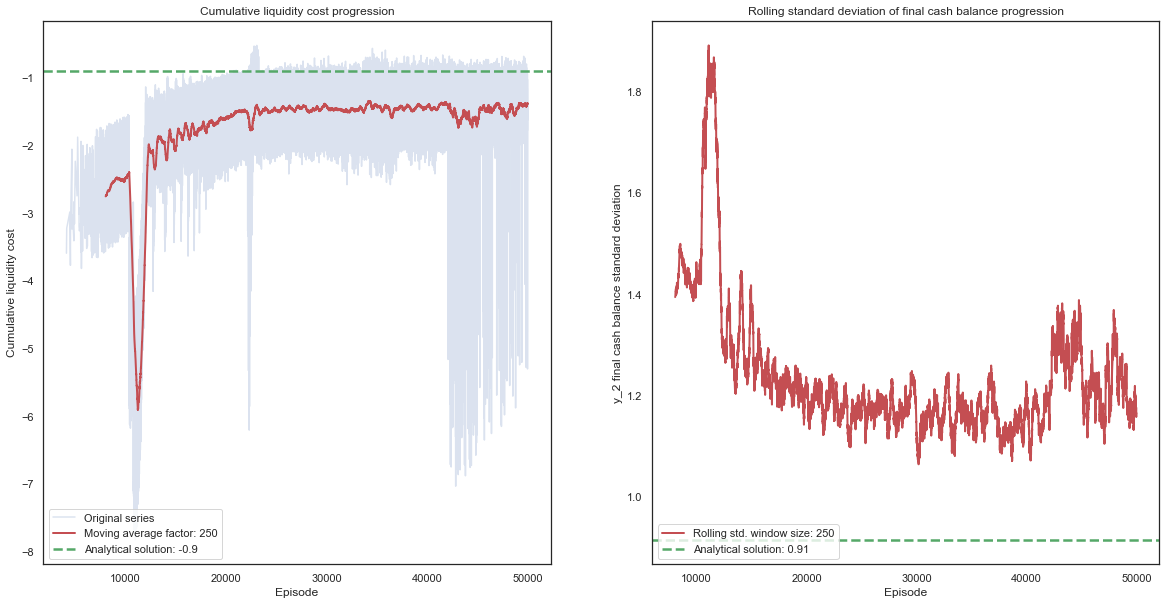

In [22]:
fig, ax = plt.subplots(1,2)
opacity = 0.2

sns.lineplot(x="episode", y=Y_1, data=df_plot_1, label="Original series", ax=ax[0], alpha=opacity, color="b")
sns.lineplot(x="episode", y=Y_1_MA, data=df_plot_1, label=f"Moving average factor: {MA}", ax=ax[0], color="r", linewidth=2)

sns.lineplot(x="episode", y=Y_2_MA, data=df_plot_1, label=f"Rolling std. window size: {MA}", ax=ax[1], color="r", linewidth=2)

ax[0].set(title="Cumulative liquidity cost progression", xlabel="Episode", ylabel="Cumulative liquidity cost")
ax[1].set(title="Rolling standard deviation of final cash balance progression", xlabel="Episode", ylabel="y_2 final cash balance standard deviation")

ax[0].axhline(policy_values["cumulative liquidity costs"], ls='--', label="Analytical solution: {}".format(round(policy_values["cumulative liquidity costs"], 2)), c="g", linewidth=2.5)
ax[1].axhline(policy_values["std"], ls='--', label="Analytical solution: {}".format(round(policy_values["std"], 2)), c="g", linewidth=2.5)

ax[0].legend(loc="lower left")
ax[1].legend(loc="lower left")

plt.savefig(fname=r"C:\Users\lukas\OneDrive\Universität\Mathematik\Bachelorarbeit\Latex\BA_main\figures\test_res\two_p_2_2.png",
            bbox_inches = 'tight', pad_inches = 0)
# plt.show()

In [14]:
mean = df_wo_greedy["agent_final_cash_balance"][-10000:].mean()
std = df_wo_greedy["agent_final_cash_balance"][-10000:].std()

In [15]:
print("mean", mean, "std", std)

mean 15.057811987304687 std 1.2976815326740163


In [24]:
mean_liq = df_wo_greedy["cumulative_liquidity_costs"][-10000:].mean()
print(f"Mean liq: {mean_liq}")
mean_x_1 = df_wo_greedy["agent_choice_of_x1"][-10000:].mean()
print(f"Mean choice x_1: {mean_x_1}")

Mean liq: -1.4750169779076274
Mean choice x_1: 5.051541003131867
